In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.stats import ortho_group
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LassoCV

In [2]:
N = 20
M = 11000 # length of time series

# Lorenz system parameters
sigma = 10.0
rho = 28.0
beta = 8.0 / 3.0

def lorenz(t, state):
    u, v, w = state
    dudt = sigma * (v - u)
    dvdt = u * (rho - w) - v
    dwdt = u * v - beta * w
    return [dudt, dvdt, dwdt]

state0 = [1.0, 1.0, 1.0]
t_span = (0, 100)
t_eval = np.linspace(t_span[0], t_span[1], M)

sol = solve_ivp(lorenz, t_span, state0, t_eval=t_eval)
t = sol.t
u, v, w = sol.y

In [3]:
np.random.seed(42)
A = 0.9 * ortho_group.rvs(N)
C = np.random.uniform(-1, 1, N); C /= np.linalg.norm(C)
x_states = np.zeros((M, N))

for i in range(1, M):
    x_states[i] = A @ x_states[i-1] + C * u.T[i] # 20x20 @ 20x1 + 20x1 * 1x1

washout, split = 1000, 7000
X_train = x_states[washout:split]
X_test = x_states[split:-1]
Y_train = u[washout+1:split+1]
Y_test = u[split+1:M]

print(f"X_train: {X_train.shape}, Y_train: {Y_train.shape}")
print(f"X_test:  {X_test.shape},  Y_test:  {Y_test.shape}")

X_train: (6000, 20), Y_train: (6000,)
X_test:  (3999, 20),  Y_test:  (3999,)


In [4]:
print('## 1. Training pure power features Lasso Regression ##')

x_train_pure = np.hstack([X_train**p for p in range(1, 5)])
X_test_pure = np.hstack([X_test**p for p in range(1, 5)])

scaler = StandardScaler()
X_train_pure_scaled = scaler.fit_transform(x_train_pure)
X_test_pure_scaled = scaler.transform(X_test_pure)
alphas_to_test = np.logspace(-6, -3, 30)

lasso_cv_pure = LassoCV(alphas=alphas_to_test, cv=5, max_iter=50000, n_jobs=-1)
lasso_cv_pure.fit(X_train_pure_scaled, Y_train)

print(f"Best Alpha: {lasso_cv_pure.alpha_}")
print(f"Sparsity: {np.sum(lasso_cv_pure.coef_ == 0)}/{lasso_cv_pure.coef_.size} zero coefficients")

## 1. Training pure power features Lasso Regression ##
Best Alpha: 0.001
Sparsity: 58/80 zero coefficients


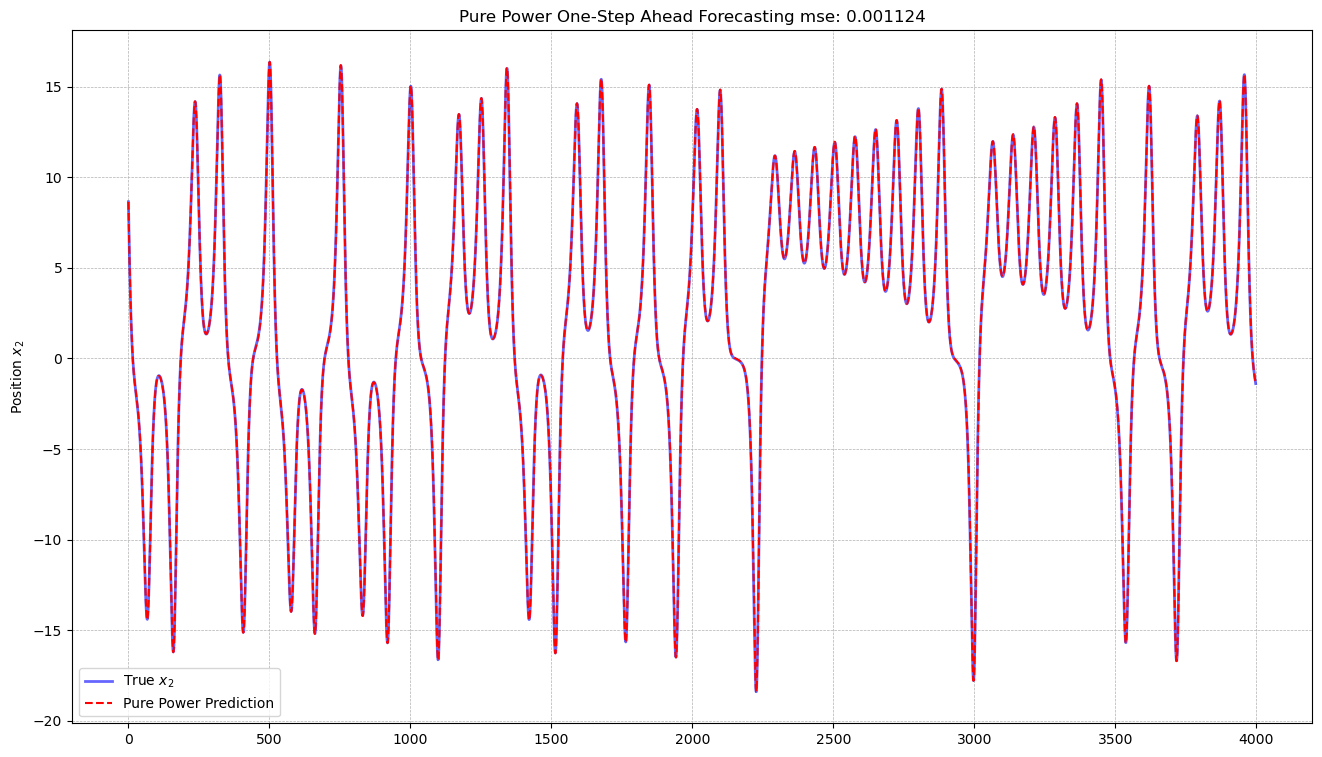

In [5]:
y_pred_pure = lasso_cv_pure.predict(X_test_pure_scaled)
mse = mse_pure = np.mean((Y_test - y_pred_pure)**2)

plt.figure(figsize=(16, 9))
plt.plot(Y_test, label="True $x_2$", color='blue', linewidth=2, alpha=0.6)
plt.plot(y_pred_pure, label="Pure Power Prediction", color='red', linestyle='--')

plt.title("Pure Power One-Step Ahead Forecasting mse: {:.6f}".format(mse_pure))
plt.ylabel("Position $x_2$")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig('../images/pure_power_forecasting.png', dpi=300)
# plt.show()

In [6]:
print('2. Training full polynomial (Multi-Task)...')

poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_full = poly.fit_transform(X_train)
X_test_full = poly.transform(X_test)
alphas_to_test = np.logspace(-5, -2, 20) 

lasso_cv_full = LassoCV(alphas=alphas_to_test, cv=3, max_iter=10000, n_jobs=-1)

scaler = StandardScaler()
X_train_full_scaled = scaler.fit_transform(X_train_full)
X_test_full_scaled = scaler.transform(X_test_full)

print("Fitting model (this might take a while)...")
lasso_cv_full.fit(X_train_full_scaled, Y_train)

print(f"Best Alpha: {lasso_cv_full.alpha_}")
n_zero = np.sum(lasso_cv_full.coef_ == 0)
n_total = lasso_cv_full.coef_.size
print(f"Sparsity: {n_zero}/{n_total} coefficients are zero ({n_zero/n_total:.2%})")

2. Training full polynomial (Multi-Task)...
Fitting model (this might take a while)...
Best Alpha: 0.01
Sparsity: 1761/1770 coefficients are zero (99.49%)


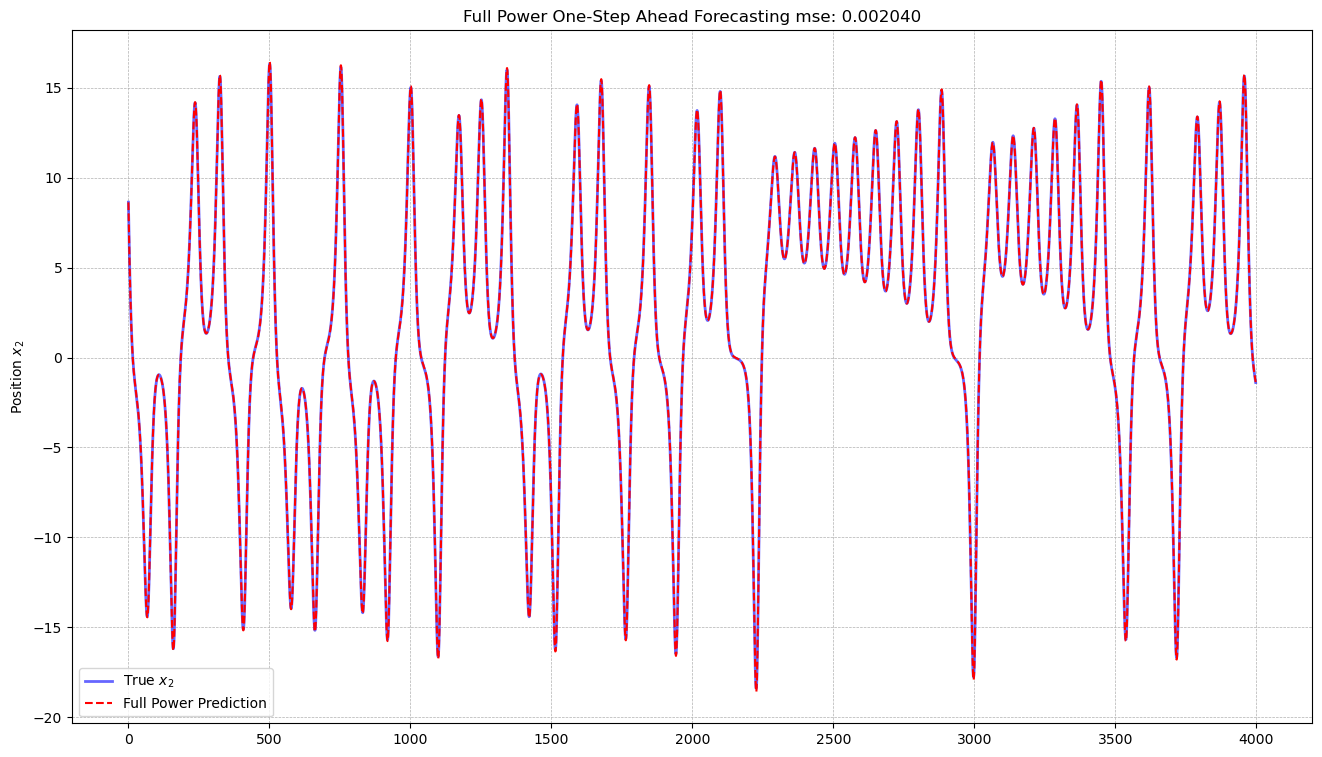

In [7]:
y_pred_full = lasso_cv_full.predict(X_test_full_scaled)
mse_full = np.mean((Y_test - y_pred_full)**2)

plt.figure(figsize=(16, 9))
plt.plot(Y_test, label="True $x_2$", color='blue', linewidth=2, alpha=0.6)
plt.plot(y_pred_full, label="Full Power Prediction", color='red',linestyle='--')
plt.title("Full Power One-Step Ahead Forecasting mse: {:.6f}".format(mse_full))
plt.ylabel("Position $x_2$")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig('../images/full_polynomial_forecasting.png', dpi=300)
# plt.show()